In [1]:
# Bibliotecas genéricas

import pandas as pd 
import numpy as np
import requests
import time
import json
import os   
import sys
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from datetime import timedelta
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent
import plotly.express as px


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Dados de Voos

In [2]:
destino = np.array(['SBKP', 'SBGR', 'SBBR', 'SBCF', 'SBSP', 'SBRJ', 'SBFL', 'SBCT',
       'SBRF', 'SBPA', 'SBSV', 'SBGL'], dtype=object)

#### Dados da ANAC

In [3]:
# Dados de voos de vra 

# SBGR - Guarulhos

# Listar todos os arquivos na pasta 'vra'
vra_files = [os.path.join('vra', f) for f in os.listdir('vra') if f.endswith('.csv')]

# Concatenar todos os arquivos da pasta 'vra' que atendem à condição
vra_list = []
for file in vra_files:
    ocorrencias = pd.read_csv(file, sep=';')
    df_filtered = ocorrencias[ocorrencias['Sigla ICAO Aeroporto Destino'].isin(destino)]
    vra_list.append(df_filtered)

vra = pd.concat(vra_list, ignore_index=True)

# Converter colunas de datas do vra para o padrão internacional ISO 8601 com horário

vra['Partida Real'] = pd.to_datetime(vra['Partida Real'],  format='%d/%m/%Y %H:%M')
vra['Chegada Real'] = pd.to_datetime(vra['Chegada Real'], format='%d/%m/%Y %H:%M')
vra['Partida Prevista'] = pd.to_datetime(vra['Partida Prevista'],  format='%d/%m/%Y %H:%M')
vra['Chegada Prevista'] = pd.to_datetime(vra['Chegada Prevista'],  format='%d/%m/%Y %H:%M')
vra['Horário de Referência para Partida'] = np.where(vra['Partida Real'].isnull(), vra['Partida Prevista'], vra['Partida Real'])
vra['Horário de Referência para Chegada'] = np.where(vra['Chegada Real'].isnull(), vra['Chegada Prevista'], vra['Chegada Real'])



vra.loc[vra['Situação Voo'] == 'REALIZADO', 'Situação Voo'] = 'Accomplished'
vra.loc[vra['Situação Voo'] == 'CANCELADO', 'Situação Voo'] = 'Canceled'


# Translate the unique values to English
translated_values = {
    'Antecipado': 'Early',
    'Pontual': 'On Time',
    'Atraso 30-60': 'Delay 30-60',
    'Atraso 60-120': 'Delay 60-120',
    'Atraso 120-240': 'Delay 120-240',
    'Atraso > 240': 'Delay > 240'
}

# Apply the translation to the 'Situação Chegada' column
vra['Situação Chegada'] = vra['Situação Chegada'].map(translated_values)
vra['Situação Partida'] = vra['Situação Partida'].map(translated_values)

# Certificar que as colunas 'Chegada Real' e 'Chegada Prevista' estão no formato datetime
vra['Chegada Real'] = pd.to_datetime(vra['Chegada Real'])
vra['Chegada Prevista'] = pd.to_datetime(vra['Chegada Prevista'])

# Adicionar a coluna 'Atraso' ao dataframe original 'vra' com a lógica desejada
vra['Atraso'] = vra.apply(
    lambda row: f"{int(((row['Chegada Real'] - row['Chegada Prevista']).total_seconds()) // 60)}"
    if pd.notnull(row['Chegada Prevista']) and pd.notnull(row['Chegada Real']) and row['Chegada Prevista'] <= row['Chegada Real'] else np.nan, axis=1)

vra['Tempo de Voo'] = vra['Horário de Referência para Chegada'] - vra['Horário de Referência para Partida']
vra['Tempo de Voo'] = vra['Tempo de Voo'].apply(lambda x: f"{int(x.total_seconds() // 60)}")

vra

/tmp/ipykernel_490000/22707733.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ocorrencias = pd.read_csv(file, sep=';')
/tmp/ipykernel_490000/22707733.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ocorrencias = pd.read_csv(file, sep=';')
/tmp/ipykernel_490000/22707733.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ocorrencias = pd.read_csv(file, sep=';')
/tmp/ipykernel_490000/22707733.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ocorrencias = pd.read_csv(file, sep=';')
/tmp/ipykernel_490000/22707733.py:11: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  ocorrencias = pd.read_csv(file, sep=';')


,Sigla ICAO Empresa Aérea,Empresa Aérea,Número Voo,Código DI,Código Tipo Linha,Modelo Equipamento,Número de Assentos,Sigla ICAO Aeroporto Origem,Descrição Aeroporto Origem,Partida Prevista,...,Chegada Real,Situação Voo,Justificativa,Referência,Situação Partida,Situação Chegada,Horário de Referência para Partida,Horário de Referência para Chegada,Atraso,Tempo de Voo
0,ACN,AZUL CONECTA LTDA. (EX TWO TAXI AEREO LTDA),5945,6,N,C208,0,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,NaT,...,2022-11-01 16:46:00,Accomplished,NaN,01/11/2022 00:00:00,NaN,NaN,2022-11-01 14:48:00,2022-11-01 16:46:00,NaN,118
1,ACN,AZUL CONECTA LTDA. (EX TWO TAXI AEREO LTDA),5122,4,N,C208,9,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,NaT,...,2022-11-02 11:58:00,Accomplished,NaN,02/11/2022 00:00:00,NaN,NaN,2022-11-02 09:45:00,2022-11-02 11:58:00,NaN,133
2,ACN,AZUL CONECTA LTDA. (EX TWO TAXI AEREO LTDA),5950,2,N,C208,9,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,NaT,...,2022-11-02 14:19:00,Accomplished,NaN,02/11/2022 00:00:00,NaN,NaN,2022-11-02 12:24:00,2022-11-02 14:19:00,NaN,115
3,ACN,AZUL CONECTA LTDA. (EX TWO TAXI AEREO LTDA),5960,2,N,C208,0,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,NaT,...,2022-12-20 11:27:00,Accomplished,NaN,20/12/2022 00:00:00,NaN,NaN,2022-12-20 09:34:00,2022-12-20 11:27:00,NaN,113
4,ACN,AZUL CONECTA LTDA. (EX TWO TAXI AEREO LTDA),5927,2,N,C208,0,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,NaT,...,2023-02-20 10:40:00,Accomplished,NaN,20/02/2023 00:00:00,NaN,NaN,2023-02-20 08:43:00,2023-02-20 10:40:00,NaN,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327435,TAM,TAM LINHAS AÉREAS S.A.,3297,1,N,A320,176,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,NaT,...,2023-04-20 08:37:00,Accomplished,NaN,20/04/2023 00:00:00,NaN,NaN,2023-04-20 07:46:00,2023-04-20 08:37:00,NaN,51
327436,TAM,TAM LINHAS AÉREAS S.A.,3429,1,N,A320,176,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,NaT,...,2023-04-20 08:48:00,Accomplished,NaN,20/04/2023 00:00:00,NaN,NaN,2023-04-20 08:08:00,2023-04-20 08:48:00,NaN,40
327437,TPA,TAMPA CARGO S.A.,4055,D,X,A332,0,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,NaT,...,2022-06-10 12:16:00,Accomplished,NaN,09/06/2022 00:00:00,NaN,NaN,2022-06-10 11:14:00,2022-06-10 12:16:00,NaN,62
327438,TPA,TAMPA CARGO S.A.,4060,4,X,A332,0,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,NaT,...,2022-06-10 12:16:00,Accomplished,NaN,09/06/2022 00:00:00,NaN,NaN,2022-06-10 11:14:00,2022-06-10 12:16:00,NaN,62


### Dados de esperas



In [4]:
# Carregando dados de esperas em voo

esperas = pd.read_csv('esperas.csv')

esperas['hora'] = pd.to_datetime(esperas['hora'], unit='ms')
esperas.rename(columns={'hora': 'time'}, inplace=True)

esperas[esperas['esperas'] > 0 ].head(20)

,esperas,time,aero
49,1,2022-06-01 01:00:00,SBCT
142,2,2022-06-01 22:00:00,SBGR
153,6,2022-06-01 09:00:00,SBKP
154,3,2022-06-01 10:00:00,SBKP
254,1,2022-06-01 14:00:00,SBSP
260,1,2022-06-01 20:00:00,SBSP
263,1,2022-06-01 23:00:00,SBSP
374,2,2022-06-02 14:00:00,SBCF
385,1,2022-06-01 01:00:00,SBCT
550,2,2022-06-01 22:00:00,SBGR


### Dados Metereológicos
Link para interpretar dados metereológicos: [[link]](https://ajuda.decea.mil.br/base-de-conhecimento/como-decodificar-o-metar-e-o-speci/)

Exemplo: 'METAR SBGL 131000Z 31015G27KT 280V350 4000 1800N R10/P2000 +TSRA FEW005 FEW010CB SCT018 BKN025 10/03 Q0995 REDZ WS R10 W12/H75='
Também é possível uitlizar bibliotecas para interpretar os dados metereológicos, como a `metar` [[link]](https://pypi.org/project/metar/)


Instalando biblioteca para interpretar dados metar: 


Função para transformar dados


In [5]:
import avwx

def get_metar_data(x):
    try:
        metar = avwx.Metar.from_report(x)
        # Organizar os dados em um dicionário
        data = {
            'station': metar.station.gps,
            'time': metar.data.time.dt,
            'wind_direction': metar.data.wind_direction.value,
            'wind_speed': metar.data.wind_speed.value,
            'temperature': metar.data.temperature.value,
            'dew_point': metar.data.dewpoint.value, 
            'visibility':metar.data.visibility.value,
            'pressure': metar.data.pressure_altitude,
            'clouds': metar.translations.clouds, 
            'wx_codes': metar.translations.wx_codes,
            'flight_rules': metar.data.flight_rules,
        }
        return data 
    except:
        return ''

#### METAR


In [6]:

# Verifica se já existe o arquivo metar_translated.csv

if not os.path.exists('metar_translated.csv'):

    # Carregando dados do METAR

    metar = pd.read_csv('metar.csv')

    # Transformando colunas de data

    metar['hora'] = pd.to_datetime(metar['hora'], unit='ms')

    # Traduzindo metar 

    metar['metar_translated'] = metar['metar'].apply(lambda x: get_metar_data(x))
    data = metar['metar_translated']
    new_columns = pd.DataFrame(data.to_dict()).T
    metar = pd.concat([metar, new_columns], axis=1)
    # drop columns metar, metar_translated and station 
    metar.drop(['metar_translated', 'station', 'metar', 'time'], axis=1, inplace=True)
    metar.to_csv('metar_translated.csv', index=False)   
else:
    metar = pd.read_csv('metar_translated.csv')
    
    
metar.drop(['time'], axis=1, inplace=True)
metar.rename(columns={'hora': 'time'}, inplace=True)
metar['time'] = pd.to_datetime(metar['time'])
    
    
metar.head()

,time,aero,wind_direction,wind_speed,temperature,dew_point,visibility,pressure,clouds,wx_codes,flight_rules
0,2022-06-01 00:00:00,SBBR,70.0,2.0,21.0,8.0,9999.0,3355.0,Sky clear,NaN,VFR
1,2022-06-01 01:00:00,SBBR,100.0,2.0,20.0,9.0,9999.0,3326.0,Sky clear,NaN,VFR
2,2022-06-01 02:00:00,SBBR,0.0,0.0,16.0,9.0,9999.0,3326.0,Sky clear,NaN,VFR
3,2022-06-01 03:00:00,SBBR,270.0,2.0,16.0,9.0,9999.0,3326.0,Sky clear,NaN,VFR
4,2022-06-01 04:00:00,SBBR,0.0,0.0,14.0,9.0,9999.0,3355.0,Sky clear,NaN,VFR


### Juntando Informações

Inserindo informações da ANAC com os parâmetros das condições dos aeroportos

In [7]:
def sortAndSaveVRAFiltered(df, start_date, end_date):
    
    # Rename columns
    df.rename(columns={
        'Sigla ICAO Empresa Aérea': 'Airline ICAO Code',
        'Empresa Aérea': 'Airline',
        'Número Voo': 'Flight Number',
        'Modelo Equipamento': 'Equipment Model',
        'Número de Assentos': 'Number of Seats',
        'Sigla ICAO Aeroporto Origem': 'Origin Airport ICAO Code',
        'Partida Prevista': 'Scheduled Departure',
        'Partida Real': 'Actual Departure',
        'Sigla ICAO Aeroporto Destino': 'Destination Airport ICAO Code',
        'Chegada Prevista': 'Scheduled Arrival',
        'Chegada Real': 'Actual Arrival',
        'Situação Voo': 'Flight Status',
        'Justificativa': 'Justification',
        'Referência': 'Reference',
        'Situação Partida': 'Departure Status',
        'Situação Chegada': 'Arrival Status',
        'Horário de Referência para Partida': 'Reference Time for Departure',
        'Horário de Referência para Chegada': 'Reference Time for Arrival',
        'time_orig': 'Origin Time',
        'wind_direction_orig': 'Origin Wind Direction',
        'wind_speed_orig': 'Origin Wind Speed',
        'temperature_orig': 'Origin Temperature',
        'dew_point_orig': 'Origin Dew Point',
        'visibility_orig': 'Origin Visibility',
        'pressure_orig': 'Origin Pressure',
        'time_dest': 'Destination Time',
        'wind_direction_dest': 'Destination Wind Direction',
        'wind_speed_dest': 'Destination Wind Speed',
        'temperature_dest': 'Destination Temperature',
        'dew_point_dest': 'Destination Dew Point',
        'visibility_dest': 'Destination Visibility',
        'pressure_dest': 'Destination Pressure',
        'esperas_orig': 'Origin runway threshold hold',
        'esperas_dest': 'Destination runway threshold hold',
        'clouds_orig': 'Origin Clouds',
        'wx_codes_orig': 'Origin Weather Codes',
        'clouds_dest': 'Destination Clouds',
        'wx_codes_dest': 'Destination Weather Codes',
        'flight_rules_orig': 'Origin Flight Rules',
        'flight_rules_dest': 'Destination Flight Rules',
        'Atraso':'Delay',
        'Tempo de Voo':'Flight Time'
        
    }, inplace=True)
    
    # Filter the dataframe based on the provided dates
    df = df[(df['Reference Time for Departure'] >= start_date) & (df['Reference Time for Departure'] <= end_date)]
    
    # Drop unnecessary columns
    df.drop(columns=['Descrição Aeroporto Destino', 'Descrição Aeroporto Origem', 'Código DI', 'Código Tipo Linha'], inplace=True)
    
    
    # Save the filtered dataframe to a CSV file
    df.to_csv('vra_filtered.csv', index=False)
    
    return df


# Check if the file already exists
if not os.path.exists('vra_filtered.csv'):
    # Perform the merging operations
    vra_modified = pd.merge_asof(
        vra.sort_values('Horário de Referência para Partida', ascending=True),
        metar.rename(columns={'aero': 'Sigla ICAO Aeroporto Origem'}).sort_values('time', ascending=True),
        left_on='Horário de Referência para Partida',
        right_on='time',
        by='Sigla ICAO Aeroporto Origem',
        direction='nearest'
    )

    # Change suffix new columns names in vra on merged_df to previsto
    # example temperature -> temperature_previsto
    vra_modified.columns = [f'{col}_orig' if col in metar.columns else col for col in vra_modified.columns]

    vra_modified = pd.merge_asof(
        vra_modified.sort_values('Horário de Referência para Chegada', ascending=True),
        metar.rename(columns={'aero': 'Sigla ICAO Aeroporto Destino'}).sort_values('time', ascending=True),
        left_on='Horário de Referência para Chegada',
        right_on='time',
        by='Sigla ICAO Aeroporto Destino',
        direction='nearest'
    )

    vra_modified.columns = [f'{col}_dest' if col in metar.columns else col for col in vra_modified.columns]

    # Drop columns hora, time_prev and time_dest
    vra_modified.drop(columns=['time_orig', 'time_dest'], inplace=True)

    vra_modified = pd.merge_asof(
        vra_modified.sort_values('Horário de Referência para Partida', ascending=True),
        esperas.rename(columns={'aero': 'Sigla ICAO Aeroporto Origem'}).sort_values('time', ascending=True),
        left_on='Horário de Referência para Partida',
        right_on='time',
        by='Sigla ICAO Aeroporto Origem',
        direction='nearest'
    )

    # Change hora column name to hora_orig
    vra_modified.columns = [f'{col}_orig' if col in esperas.columns else col for col in vra_modified.columns]

    vra_modified = pd.merge_asof(
        vra_modified.sort_values('Horário de Referência para Chegada', ascending=True),
        esperas.rename(columns={'aero': 'Sigla ICAO Aeroporto Destino'}).sort_values('time', ascending=True),
        left_on='Horário de Referência para Chegada',
        right_on='time',
        by='Sigla ICAO Aeroporto Destino',
        direction='nearest'
    )

    # Change hora column name to hora_dest
    vra_modified.columns = [f'{col}_dest' if col in esperas.columns else col for col in vra_modified.columns]

    vra_modified = sortAndSaveVRAFiltered(vra_modified, '2022-03-26', '2023-05-13')
    
else:
    # Load the dataframe from the CSV file
    vra_modified = pd.read_csv('vra_filtered.csv')

vra_modified

,Airline ICAO Code,Airline,Flight Number,Equipment Model,Number of Seats,Origin Airport ICAO Code,Scheduled Departure,Actual Departure,Destination Airport ICAO Code,Scheduled Arrival,...,Destination Dew Point,Destination Visibility,Destination Pressure,Destination Clouds,Destination Weather Codes,Destination Flight Rules,Origin runway threshold hold,Origin Time,Destination runway threshold hold,Destination Time
0,GLO,GOL LINHAS AÉREAS S.A. (EX- VRG LINHAS AÉREAS ...,2028,B38M,186,SBGL,NaN,2022-03-26 16:32:00,SBRF,NaN,...,24.0,9999.0,69.0,"Few clouds at 1300ft, Broken layer at 1900ft -...",Vicinity Showers,MVFR,0,2022-06-01 00:00:00,0,2022-06-01 00:00:00
1,SID,SIDERAL LINHAS AÉREAS LTDA.,9412,B73Y,0,SBCF,2022-06-01 00:40:00,2022-06-01 00:40:00,SBGR,2022-06-01 02:00:00,...,15.0,9999.0,2290.0,"Scattered clouds at 800ft, Overcast layer at 1...",NaN,MVFR,0,2022-06-01 01:00:00,0,2022-06-01 02:00:00
2,SID,SIDERAL LINHAS AÉREAS LTDA.,9306,B73Y,0,SBBR,2022-06-01 00:15:00,2022-06-01 00:15:00,SBGR,2022-06-01 01:55:00,...,15.0,9999.0,2290.0,"Scattered clouds at 800ft, Overcast layer at 1...",NaN,MVFR,0,2022-06-01 00:00:00,0,2022-06-01 02:00:00
3,TTL,TOTAL LINHAS AÉREAS S.A.,5683,B722,0,SBGR,2022-06-01 02:00:00,2022-06-01 02:16:00,SBGL,2022-06-01 03:00:00,...,20.0,9999.0,-25.0,"Scattered clouds at 1800ft, Overcast layer at ...",NaN,MVFR,0,2022-06-01 02:00:00,0,2022-06-01 03:00:00
4,SID,SIDERAL LINHAS AÉREAS LTDA.,9303,B734,0,SBGR,2022-06-01 02:40:00,2022-06-01 03:04:00,SBGL,2022-06-01 03:40:00,...,20.0,9999.0,-25.0,"Scattered clouds at 1800ft, Overcast layer at ...",NaN,MVFR,0,2022-06-01 03:00:00,0,2022-06-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326644,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S/A,4885,A21N,214,SBKP,2023-05-12 22:50:00,2023-05-12 22:54:00,SBRF,2023-05-13 01:55:00,...,22.0,9999.0,10.0,Few clouds at 2500ft - Reported AGL,NaN,VFR,0,2023-05-12 23:00:00,0,2023-05-13 02:00:00
326645,TAM,TAM LINHAS AÉREAS S.A.,3358,A320,180,SBGR,2023-05-12 23:35:00,2023-05-12 23:36:00,SBSV,2023-05-13 01:50:00,...,24.0,9999.0,41.0,Few clouds at 1800ft - Reported AGL,NaN,VFR,0,2023-05-13 00:00:00,0,2023-05-13 02:00:00
326646,TAM,TAM LINHAS AÉREAS S.A.,3382,A321,224,SBGR,2023-05-12 22:50:00,2023-05-12 22:58:00,SBRF,2023-05-13 01:50:00,...,22.0,9999.0,10.0,Few clouds at 2500ft - Reported AGL,NaN,VFR,0,2023-05-12 23:00:00,0,2023-05-13 02:00:00
326647,GLO,GOL LINHAS AÉREAS S.A. (EX- VRG LINHAS AÉREAS ...,2086,B38M,186,SBGL,2023-05-12 23:55:00,2023-05-12 23:44:00,SBRF,2023-05-13 02:45:00,...,22.0,9999.0,10.0,Few clouds at 2500ft - Reported AGL,NaN,VFR,0,2023-05-13 00:00:00,0,2023-05-13 02:00:00


### Visualização dos dados

#### Status de Partida

/tmp/ipykernel_490000/373739565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=vra_modified, x='Departure Status', palette='viridis')


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

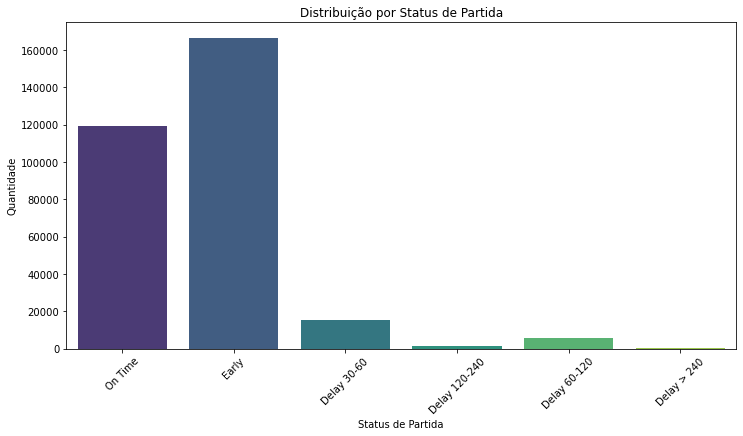

In [8]:
# Distribuição por status de partida
plt.figure(figsize=(12, 6))
sns.countplot(data=vra_modified, x='Departure Status', palette='viridis')
plt.title('Distribuição por Status de Partida')
plt.xlabel('Status de Partida')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)

#### Status de Chegada

/tmp/ipykernel_490000/2421783234.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=vra_modified, x='Arrival Status', palette='viridis')


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

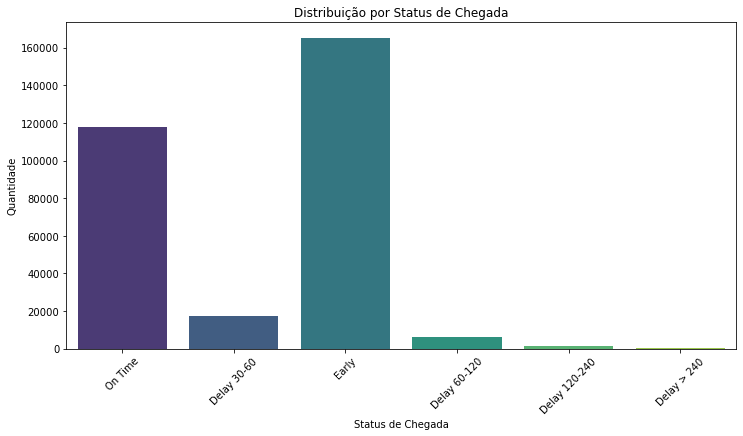

In [9]:
# Distribuição por status de partida
plt.figure(figsize=(12, 6))
sns.countplot(data=vra_modified, x='Arrival Status', palette='viridis')
plt.title('Distribuição por Status de Chegada')
plt.xlabel('Status de Chegada')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)

In [10]:
vra_modified['Departure Status'].value_counts()

Departure Status
Early            166452
On Time          119297
Delay 30-60       15100
Delay 60-120       5484
Delay 120-240      1454
Delay > 240         341
Name: count, dtype: int64

Arrival Status                    Early    On Time  Delay 30-60  Delay 60-120  \
Origin runway threshold hold                                                    
0                             54.961427  37.756639     5.058869      1.687577   
1                             42.597259  43.699795     9.592062      3.283982   
2                             38.063754  44.155844    10.979929      5.501771   
3                             30.469192  48.162804    14.471453      5.370266   
4                             30.288462  46.955128    15.464744      5.689103   
5                             26.480836  47.038328    15.156794      8.362369   
6                             28.467153  45.255474    16.058394      7.299270   
7                             22.113022  45.454545    21.375921      8.599509   
8                             28.660436  45.482866    16.822430      7.165109   
9                             17.131474  47.808765    21.513944     11.553785   
10                          

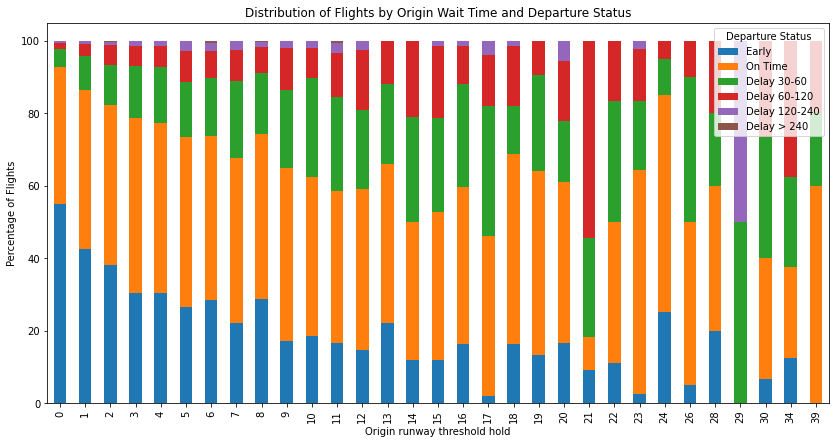

In [11]:
# Agrupar por 'Origin Wait Time' e 'Departure Status' e contar o número de ocorrências
wait_time_status = vra_modified.groupby(['Origin runway threshold hold', 'Arrival Status']).size().unstack(fill_value=0)

# Reorganizar as colunas na ordem desejada
wait_time_status = wait_time_status.reindex(columns=['Early', 'On Time', 'Delay 30-60', 'Delay 60-120', 'Delay 120-240', 'Delay > 240'])

# Calcular o percentual de cada status de partida
wait_time_status_percent = wait_time_status.div(wait_time_status.sum(axis=1), axis=0) * 100

# Exibir o resultado
print(wait_time_status_percent)

# Plotting the distribution of 'Origin Wait Time' by 'Departure Status'
wait_time_status_percent.plot(figsize=(14, 7), kind='bar', stacked=True)
plt.xlabel('Origin runway threshold hold')
plt.ylabel('Percentage of Flights')
plt.title('Distribution of Flights by Origin Wait Time and Departure Status')
plt.legend(title='Departure Status')
plt.show()



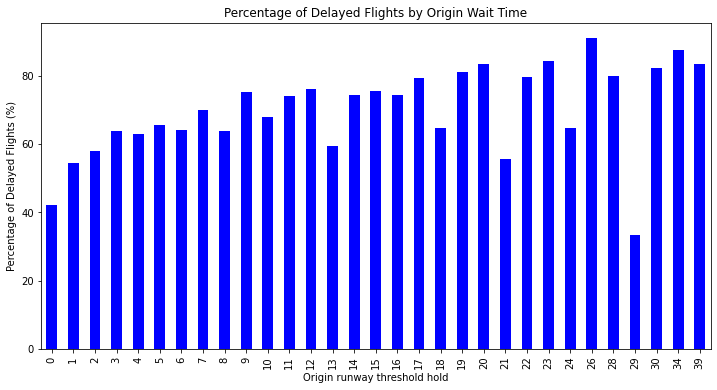

In [14]:
# Calculate the total number of flights for each 'Origin Wait Time'
total_flights = vra_modified.groupby('Origin runway threshold hold').size()

# Calculate the number of delayed flights for each 'Origin Wait Time'
delayed_flights = vra_modified[(vra_modified['Departure Status'] != 'On time') & 
                               (vra_modified['Departure Status'] != 'Early') & 
                               (~vra_modified['Departure Status'].isna())].groupby('Origin runway threshold hold').size()

# Calculate the percentage of delayed flights
percentage_delayed = (delayed_flights / total_flights) * 100

# Plot the percentage of delayed flights
percentage_delayed.plot(kind='bar', figsize=(12, 6), color='blue')
plt.xlabel('Origin runway threshold hold')
plt.ylabel('Percentage of Delayed Flights (%)')
plt.title('Percentage of Delayed Flights by Origin Wait Time')
plt.show()

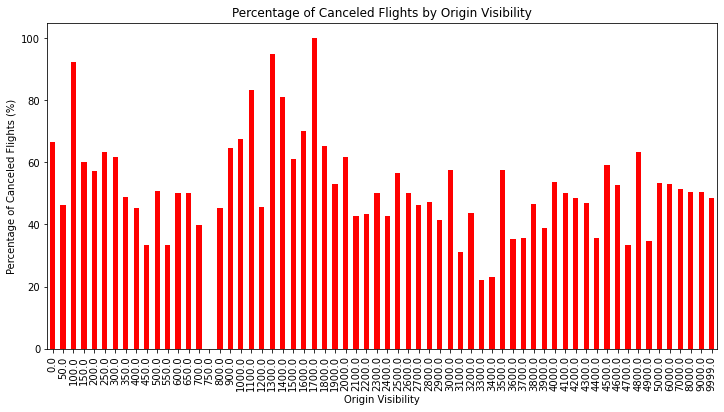

In [15]:
# Calculate the total number of flights for each 'Origin Visibility'
total_flights_visibility = vra_modified.groupby('Origin Visibility').size()

# Calculate the number of canceled flights for each 'Origin Visibility'
canceled_flights_visibility = vra_modified[(vra_modified['Flight Status'] == 'CANCELADO') | 
                                            ((vra_modified['Departure Status'] != 'On time') & 
                                            (vra_modified['Departure Status'] != 'Early'))].groupby('Origin Visibility').size()

# Calculate the percentage of canceled flights
percentage_canceled_visibility = (canceled_flights_visibility / total_flights_visibility) * 100

# Plot the percentage of canceled flights
percentage_canceled_visibility.plot(kind='bar', figsize=(12, 6), color='red')
plt.xlabel('Origin Visibility')
plt.ylabel('Percentage of Canceled Flights (%)')
plt.title('Percentage of Canceled Flights by Origin Visibility')
plt.show()

##### Problemas por condições de voo

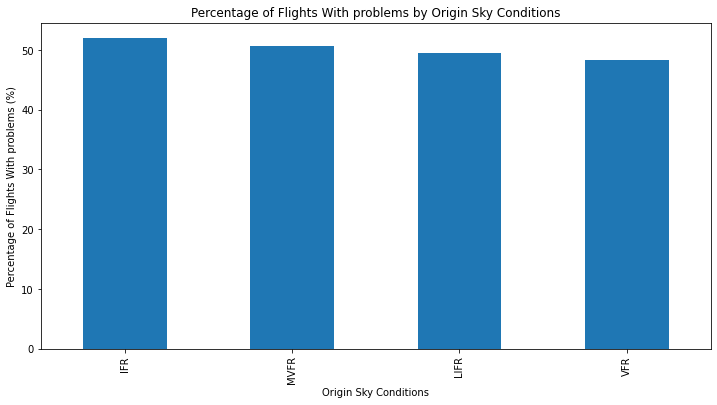

In [18]:
# Calculate the total number of flights for each 'Origin Flight Rules'
total_flights_rules = vra_modified.groupby('Origin Flight Rules').size()

# Calculate the number of flights with problems for each 'Origin Sky Conditions'
canceled_total_flights_rules = vra_modified[(vra_modified['Flight Status'] == 'Canceled') | 
                                            ((vra_modified['Departure Status'] != 'On time') & 
                                            (vra_modified['Departure Status'] != 'Early'))].groupby('Origin Flight Rules').size()

# Calculate the percentage of flights with problems
percentage_canceled_sky_conditions = (canceled_total_flights_rules / total_flights_rules) * 100

# Plot the percentage of flights with problems
percentage_canceled_sky_conditions.nlargest(50).plot(kind='bar', figsize=(12, 6))
plt.xlabel('Origin Sky Conditions')
plt.ylabel('Percentage of Flights With problems (%)')
plt.title('Percentage of Flights With problems by Origin Sky Conditions')
plt.show()

# Display the values of flights with problems


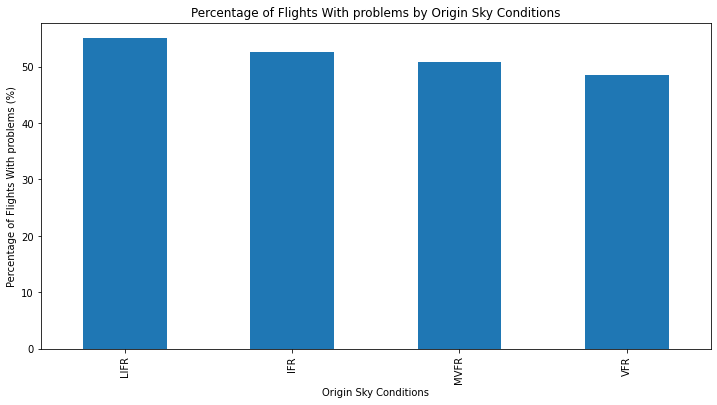

In [19]:
# Calculate the total number of flights for each 'Origin Flight Rules'
total_flights_rules = vra_modified.groupby('Destination Flight Rules').size()

# Calculate the number of flights with problems for each 'Origin Sky Conditions'
canceled_total_flights_rules = vra_modified[(vra_modified['Flight Status'] == 'Canceled') | 
                                            ((vra_modified['Arrival Status'] != 'On time') & 
                                            (vra_modified['Arrival Status'] != 'Early'))].groupby('Origin Flight Rules').size()

# Calculate the percentage of flights with problems
percentage_canceled_sky_conditions = (canceled_total_flights_rules / total_flights_rules) * 100

# Plot the percentage of flights with problems
percentage_canceled_sky_conditions.nlargest(50).plot(kind='bar', figsize=(12, 6))
plt.xlabel('Origin Sky Conditions')
plt.ylabel('Percentage of Flights With problems (%)')
plt.title('Percentage of Flights With problems by Origin Sky Conditions')
plt.show()

# Display the values of flights with problems

<AxesSubplot:xlabel='Origin Weather Codes'>

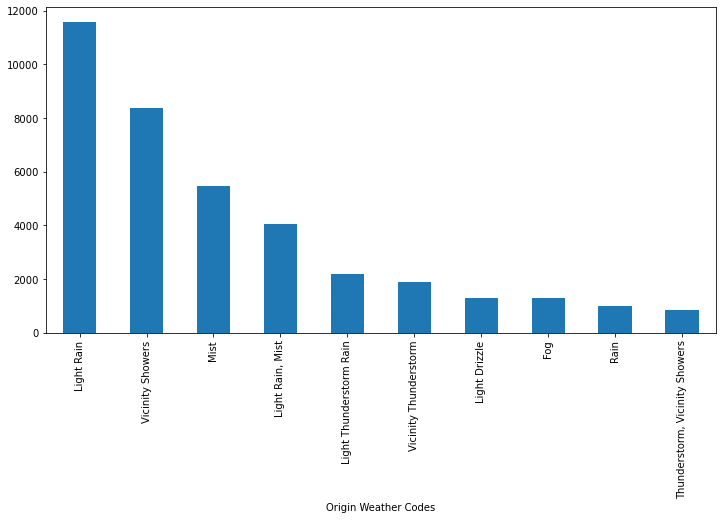

In [20]:
vra_modified.value_counts('Origin Weather Codes').nlargest(10).plot(kind='bar', figsize=(12, 6))

### Dados de ocorrência 

In [23]:

# Ocorrências no tráfego aéreo brasileiro

if not os.path.exists('ocorrencias.csv'):
    url = 'https://sistema.cenipa.aer.mil.br/cenipa/media/opendata/ocorrencia/V_OCORRENCIA_AMPLA.csv'
    r = requests
    ocorrencias = pd.read_csv('V_OCORRENCIA_AMPLA.csv', sep=';', header=1)
    ocorrencias['Data_da_Ocorrencia'] = pd.to_datetime(ocorrencias['Data_da_Ocorrencia'], format='mixed')
    ocorrencias_cenipa = pd.read_excel('ocorrencias.xlsx')

    ocorrencias_merged = pd.merge(ocorrencias_cenipa, ocorrencias[['Data_da_Ocorrencia', 'Matricula', 'Historico', 'UF', 'Municipio']],
                                left_on=['Data', 'Matrícula', 'UF', 'Localidade'], 
                                right_on=['Data_da_Ocorrencia', 'Matricula', 'UF', 'Municipio'],
                                how='left')

    ocorrencias_merged[list(ocorrencias_cenipa.columns) + ['Historico']].drop_duplicates().to_csv('ocorrencias.csv', index=False)
else:
    ocorrencias = pd.read_csv('ocorrencias.csv')

In [24]:
ocorrencias.rename(columns={
    'N° ocorrência': 'Occurrence Number',
    'Data': 'Date',
    'Matrícula': 'Registration',
    'Classificação': 'Classification',
    'Tipo': 'Type',
    'Localidade': 'Location',
    'UF': 'State',
    'Aeródromo': 'Aerodrome',
    'Operação': 'Operation',
    'Status': 'Status',
    'Link': 'Link',
    'Historico': 'History'
}, inplace=True)

ocorrencias.to_csv('ocorrencias.csv', index=False)

Salvando arquivo em .csv